In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in  enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
mnist.data.shape

(70000, 784)

In [6]:
type(mnist)

sklearn.utils.Bunch

In [7]:
X, y = mnist['data'], mnist['target']

In [8]:
X.shape, y.shape

((70000, 784), (70000,))

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

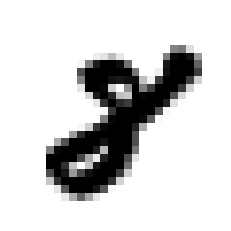

In [10]:
some_digit = X[52000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [12]:
y[52000]

8

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
import numpy as np

Shuffling data is dangerous in case of time-series data and that should be obvious :) though shuffeling is done so that cross-validation folds will be similar

In [15]:
shuffeling_index = np.random.permutation(60000)

In [16]:
X_train, y_train = X[shuffeling_index], y[shuffeling_index]

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
sgd_clf.predict([some_digit])

array([False])

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.97005, 0.94655, 0.9656 ])

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [26]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clon_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clon_clf.fit(X_train_folds, y_train_folds)
    clon_prediction = clon_clf.predict(X_test_fold)
    n_correct = sum(clon_prediction == y_test_fold)
    print(n_correct/ len(clon_prediction))

C:\Users\shinigami\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.97005
0.94655
0.9656


In [25]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clon_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clon_clf.fit(X_train_folds, y_train_folds)
    clon_prediction = clon_clf.predict(X_test_fold)
    n_correct = sum(clon_prediction == y_test_fold)
    print(n_correct/ len(clon_prediction))

0.9724
0.96385
0.9563


In [27]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        

In [28]:
never_5 = Never5Classifier()

cross_val_score(never_5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91025, 0.9089 , 0.9098 ])

That's why accuracy is not preferred matrix as performance measure because it fails in skewed data (data which has certain quantities more than other)

#### Confusion Matrix
another method to calculate performance measure. The general idea is to calculate number of times instances of class `A`
is classified as class `B`

e.g 5 classified as 3

In [33]:
from sklearn.model_selection import cross_val_predict

cross_val_predict is same as cross_val_score now it just returns predictions rather estimator's scores

In [34]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(y_train_5, y_train_pred)

array([[53223,  1356],
       [ 1000,  4421]], dtype=int64)

each row in confusion matrix represent an actual class while each column represents a predicted class. It is just like precision and recall but with matrix

In [37]:
y_train_5_perfect_predict = y_train_5

In [38]:
confusion_matrix(y_train_5, y_train_5_perfect_predict)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precison = TP / (TP + FP) 

TP: True Positive FP: False Positive

Recall or Sensitivity or True Positive Rate(TPR)= TP / (TP + FN)

FN: False Negative



In [39]:
from sklearn.metrics import precision_score, recall_score

In [40]:
precision_score(y_train_5, y_train_pred)

0.7652760948589233

In [41]:
recall_score(y_train_5, y_train_pred)

0.8155321896329091

basically precision je aahe na tyacha meaning aahe:je total number of true 5 aahet tyanchya peki kiti barobar olakhlet toh percentage number mhnje precision

recall: je 5 olakhlet (identified) tya peki khare 5 cha percentage kiti aahet



### F1-Score

f1-score is harmonic mean of precision and recall
while regular mean treates all values equally while harmonic mean gives much more weight to low values. as result classifier only get a high F1 score if both recall and precision both are high

F1-Score = TP /(TP + (FN + FP)/2)

In [42]:
from sklearn.metrics import f1_score

In [43]:
f1_score(y_train_5, y_train_pred)

0.7896052866583319

F1-score favors classifire that have similar precision and recall.

##### e.g.
1) suppose you trained a classifier to detect videos safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe videos (high precision), rather than a classifier that has a mch higher recall but lets a few really bad videos show up in your prodct(in such cases you want to add human pipeline).

1) on the other hand, suppose you train classifier to detect shoplifters on surveillance images:it is probably fine if your classifier has only 30% precision as long as it has 90% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught)


#### Increasing precision reduce recall and vice versa. this is precision-recall tradeoff



In [44]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [45]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

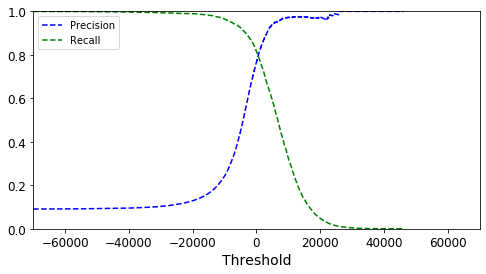

In [56]:
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
plt.show()

Precision may sometimes go down when you raise the threshold that's why it's curve is bumpier. on the other hand recall can only go down when the threshold is increased.

### ROC Curve

Receiver Operating Characteristic (ROC)